# Redefining NBA Positions Through Unsupervised Learning

I'll be scraping 2016-2017 player data from basketballreference.com, then normalizing data so that we only look at how each players stats compare to their other stats proportionally, and then using k-means to recluster players into 5 new positions.

I'll then explore which players fall into which positions, and attempt to redefine the five new positions according to their defining stat categories.

In [1]:
import pandas as pd
import numpy as np
import scrapy
import requests
from scrapy.selector import Selector
from scrapy.http import HtmlResponse
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('white')

In [2]:
# getting the HTML for the whole page

response = requests.get("http://www.basketball-reference.com/leagues/NBA_2017_totals.html")
HTML = response.text  
HTML[0:150]

u'<!DOCTYPE html>\n<html data-version="klecko-" data-root="/home/bbr/build" itemscope itemtype="http://schema.org/WebSite" lang="en" class="no-js" >\n<hea'

In [3]:
players = Selector(text=HTML).xpath("//tbody/tr[@class='full_table']").extract()

In [5]:
data = []

for player in players:
    
    name = Selector(text=player).xpath(".//td[@data-stat='player']//text()").extract()[0]
    position = Selector(text=player).xpath(".//td[@data-stat='pos']//text()").extract()[0]
    age = Selector(text=player).xpath(".//td[@data-stat='age']//text()").extract()[0]
    games_played = Selector(text=player).xpath(".//td[@data-stat='g']//text()").extract()[0]
    games_started = Selector(text=player).xpath(".//td[@data-stat='gs']//text()").extract()[0]
    mp = Selector(text=player).xpath(".//td[@data-stat='mp']//text()").extract()[0]
    fg = Selector(text=player).xpath(".//td[@data-stat='fg']//text()").extract()[0]
    fga = Selector(text=player).xpath(".//td[@data-stat='fga']//text()").extract()[0]
    #fg_pct = Selector(text=player).xpath(".//td[@data-stat='fg_pct']//text()").extract()[0]
    fg_3 = Selector(text=player).xpath(".//td[@data-stat='fg3']//text()").extract()[0]
    fg_3_a = Selector(text=player).xpath(".//td[@data-stat='fg3a']//text()").extract()[0]
    #fg3_pct = Selector(text=player).xpath(".//td[@data-stat='fg3_pct']//text()").extract()[0]
    fg_2 = Selector(text=player).xpath(".//td[@data-stat='fg2']//text()").extract()[0]
    fg_2_a = Selector(text=player).xpath(".//td[@data-stat='fg2a']//text()").extract()[0]
    #fg2_pct = Selector(text=player).xpath(".//td[@data-stat='fg2_pct']//text()").extract()[0]
    #effective_fg_pct = Selector(text=player).xpath(".//td[@data-stat='efg_pct']//text()").extract()[0]
    ft = Selector(text=player).xpath(".//td[@data-stat='ft']//text()").extract()[0]
    fta = Selector(text=player).xpath(".//td[@data-stat='fta']//text()").extract()[0]
    #ft_pct = Selector(text=player).xpath(".//td[@data-stat='ft_pct']//text()").extract()[0]
    orb = Selector(text=player).xpath(".//td[@data-stat='orb']//text()").extract()[0]
    drb = Selector(text=player).xpath(".//td[@data-stat='drb']//text()").extract()[0]
    trb = Selector(text=player).xpath(".//td[@data-stat='trb']//text()").extract()[0]
    ast = Selector(text=player).xpath(".//td[@data-stat='ast']//text()").extract()[0]
    stl = Selector(text=player).xpath(".//td[@data-stat='stl']//text()").extract()[0]
    blk = Selector(text=player).xpath(".//td[@data-stat='blk']//text()").extract()[0]
    tov = Selector(text=player).xpath(".//td[@data-stat='tov']//text()").extract()[0]
    pf = Selector(text=player).xpath(".//td[@data-stat='pf']//text()").extract()[0]
    pts = Selector(text=player).xpath(".//td[@data-stat='pts']//text()").extract()[0]

    player_dict = {
        'player': name,
        'pos': position,
        'age': age,
        'gp': games_played,
        'gs': games_started,
        'mp': mp,
        'fg': fg,
        'fga': fga,
        #'fg_pct': fg_pct,
        'fg_3': fg_3,
        'fg_3_a': fg_3_a,
        #'fg_3_pct': fg3_pct,
        'fg_2': fg_2,
        'fg_2_a': fg_2_a,
        #'fg_2_pct': fg2_pct,
        #'effective_fg_pct': effective_fg_pct,
        'ft': ft,
        'fta': fta,
        #'ft_pct': ft_pct,
        'orb': orb,
        'drb': drb,
        'trb': trb,
        'ast': ast,
        'stl': stl,
        'blk': blk,
        'tov': tov,
        'pf': pf,
        'pts': pts
    }
    
    data.append(player_dict)

df = pd.DataFrame(data)



In [6]:
df.to_csv("2016_2017_player_stats.csv")

## Noramalizing

Because I'm not interested in how many points or rebounds a players scores overall, but more so what amount of their contribution is comprised of particular stats I want to do two transformation steps before clustering:

1.  Min Max scale my data, so that all stats are on the same scale.  I don't want someone to be more defined by their points than rebounds just because people generally score more points than rebounds.
2.  Calculate what percentage of one's overall stats each stat makes.  This will represent the individual contribution of each stat category to their personal overall stat make up.  I'm concerned with what particular skills players excel at relative to their other skills, rather than relative to other players.

Another way to approach step 2 would be to divide all the stat categories by minutes played to get stats/minute, but that's going to end up being a measure of a players skill and efficiency on the floor.  I'm not trying to measure how good a player is at making the contribution they're making on the floor, but rather what they're doing.  If JaVale McGee and Dwight Howard were hypothetically to play the same minutes, and contribute to the exact same stat categories, but Dwight Howard go twice as much of every stat, I don't want to categorize them into different positions, they're still both centers.

In [2]:
df = pd.read_csv("./2016_2017_player_stats.csv")

In [3]:
del(df['Unnamed: 0'])

In [4]:
df_norm = df.copy()
df_norm.index = df.player.values

In [5]:
del(df_norm['player'])
del(df_norm['pos'])

# converting data to floats
for c in df_norm.columns:
    df_norm[c] = df_norm[c].astype(float)

# I want to go from season stats to per game averages.

for c in df_norm.columns:
    if (c != 'age') and (c != 'gp') and (c != 'gs'):
        df_norm[c] = df_norm[c] / df_norm['gp']


from sklearn.preprocessing import MinMaxScaler

min_max = MinMaxScaler()

X = min_max.fit_transform(df_norm)

df_clustering = pd.DataFrame(X, columns=df_norm.columns, index=df.player.values)

Before going to the percentage of player's stats step, I want to choose which stats I'm going to cluster on and drop the rest.

# Stat Selection

We need to make sure we only select stats that are independent from each other.  We don't want to be double counting particular stat categories, because it will give them additional weight in the clustering process.  for instance, total rebounds is going to be correlated with defensive and offensive rebounds, if we include total we'll be double counting those contributions.  similarly with points, fg_2 and fg_3 are going to be correlated, because points goes up for every 2 and 3.  Attempts are also going to be correlated with makes, so we should probably just include one stat or the other.

In [6]:
# making a new dataframe
df_norm = df_clustering.copy()

In [117]:
# Let's look at a heatmap of correlations to get an idea of what stats seem to be connected to eachother.

def correlation_heat_map(df):
    corrs = df.corr()
    
    # set figure size
    fig, ax = plt.subplots(figsize = (13, 8))
    
    # generate a mask for the upper triagle 
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    #plot heatmap
    ax = sns.heatmap(corrs, mask=mask, annot = True, cbar=False)
    
    #resize labels
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)
    ax.set_title("Correlation Heatmap of Player Stats", size=15)
    
    plt.show()

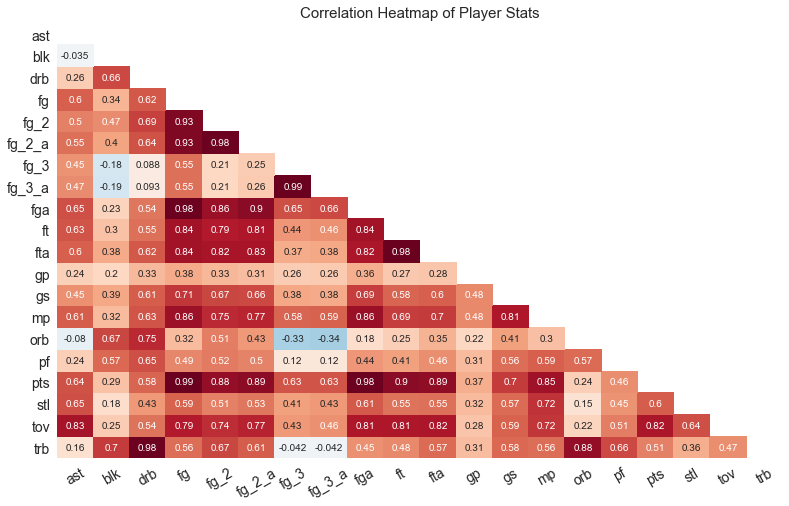

In [118]:
correlation_heat_map(df[[c for c in df.columns if c != 'age' and c != 'new_pos']])

We need to be wary of anything that's really highly correlated.

Obvious candidates to be cut:
- fg, fg_a
- trb
- fg_2_a, fg_3_a, 
- mp
- gs
- gp
- pts

notes:
- assists and turnovers are highly correlated, might be better to use just assists



In [7]:
# age is not a bball stat
del(df_norm['age'])
del(df_norm['trb'])
del(df_norm['fg'])
del(df_norm['fga'])
del(df_norm['fta'])
del(df_norm['gp'])
del(df_norm['gs'])
del(df_norm['mp'])
del(df_norm['tov'])
del(df_norm['pts'])
del(df_norm['fg_3_a'])
del(df_norm['fg_2_a'])

In [8]:
def calculate_row_pct(row):
    total = row.sum()
    for c in df_norm.columns:
        row[c] = row[c] / total
    return row

In [9]:
df_morphed = df_norm.apply(calculate_row_pct, axis=1)

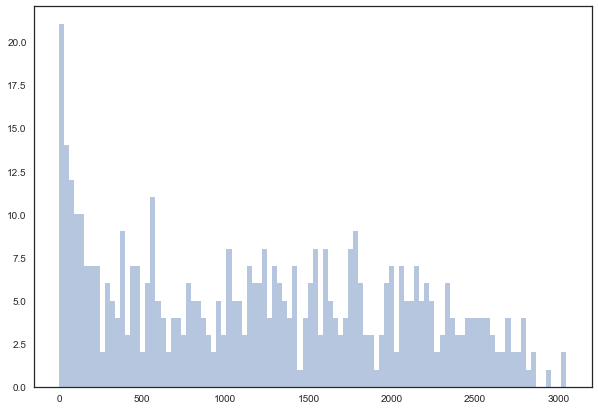

In [47]:
# I want to get rid of players who only played a handful of minutes.
plt.figure(figsize=(10,7))
sns.distplot(df['mp'].values.astype(int), bins=100, kde=False)

In [48]:
# Going to drop any player who played less than 250 minutes

In [10]:
df['mp'] = df['mp'].astype(int)

bools = df['mp'] >= 250

df_morphed = df_morphed.loc[bools.values, :]

df = df.loc[bools.values, :]

## Unsupervised Learning + Clustering

I want to use K-means clustering to now group together the players into 5 new positions

In [119]:
df_morphed.columns

Index([u'ast', u'blk', u'drb', u'fg_2', u'fg_3', u'ft', u'orb', u'pf', u'stl'], dtype='object')

In [11]:
from sklearn.cluster import k_means

kmeans = k_means(df_morphed, n_clusters=5)

In [12]:
df_pos = df_morphed.copy()
df_pos['new_pos'] = kmeans[1]

In [14]:
# let's look at the silhouette score to get an idea of how well differentiated these positions are.

from sklearn.metrics import silhouette_score

silhouette_score(df_pos, kmeans[1])

0.85792739174842336

In [52]:
df['new_pos'] = kmeans[1]

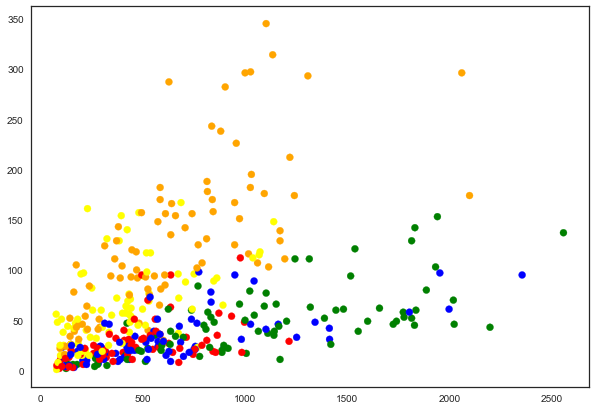

In [53]:
colors = ['red', 'blue', 'green', 'orange', 'yellow']
color_map = [colors[i] for i in df.new_pos]

plt.figure(figsize=(10,7))
plt.scatter(df.pts, df.orb, c=color_map)

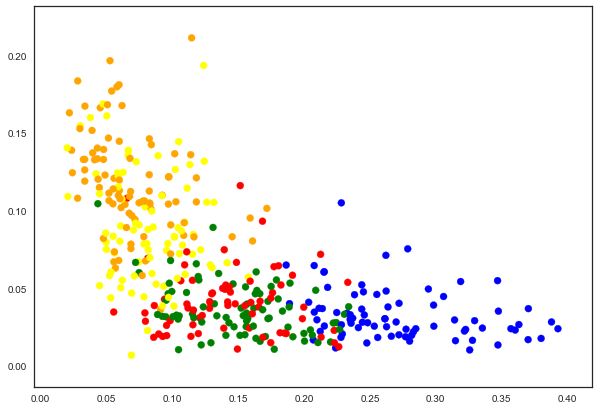

In [54]:
colors = ['red', 'blue', 'green', 'orange', 'yellow']
color_map = [colors[i] for i in df.new_pos]

plt.figure(figsize=(10,7))
plt.scatter(df_morphed.ast, df_morphed.orb, c=color_map)

In [55]:
df[df['player'] == 'Kevin Durant']

,age,ast,blk,drb,fg,fg_2,fg_2_a,fg_3,fg_3_a,fga,...,mp,orb,pf,player,pos,pts,stl,tov,trb,new_pos
118,28,300,99,474,551,434,714,117,312,1026,...,2070,39,117,Kevin Durant,SF,1555,66,138,513,2


In [56]:
df.player = df_pos.index

# Old V. New Postions

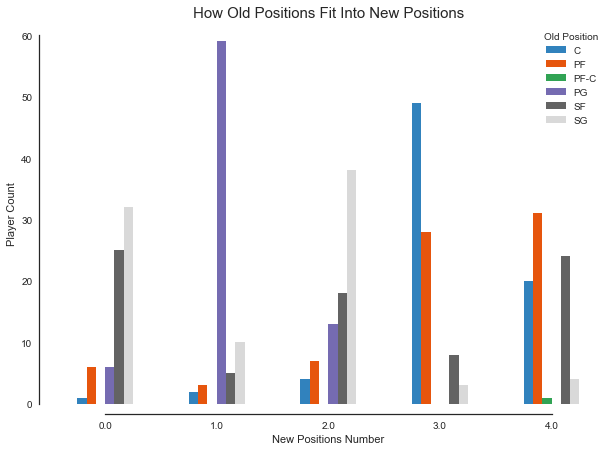

In [102]:
# How do our new positions compare to old positions?

old_v_new = df[['pos', 'new_pos']].groupby(['new_pos', 'pos']).size().unstack()
old_v_new.plot(kind='bar', figsize=(10,7), colormap="Vega20c")
plt.title("How Old Positions Fit Into New Positions", size=15)
plt.xlabel("New Positions Number")
plt.ylabel("Player Count")
plt.legend(title="Old Position")
sns.despine(offset=10, trim=True);

# How do the Different Positions Stack Up?

Let's look at the stats where different positions are weak and strong to get an idea of what stats define different positions

In [58]:
df_per_game = df.copy()

In [59]:
not_val_c = ['player', 'pos']

# changing counting stats to floats from objects.
for c in df_per_game.columns:
    if c not in not_val_c:
        df_per_game[c] = df_per_game[c].astype(float)

not_per_game_stats = ['age', 'gp', 'gs', 'player', 'pos', 'new_pos']

# converting to per game numbers
for c in df_per_game.columns:
    if c not in not_per_game_stats:
        df_per_game[c] = df_per_game[c] / df_per_game['gp']

In [60]:
# rounding stats to 1 decimal place.
for c in df_per_game.columns:
    if c not in not_per_game_stats:
        df_per_game[c] = [round(stat, 1) for stat in df_per_game[c]]

In [61]:
from scipy import stats

df_percentiles = df_per_game.copy()

not_val_c.append('new_pos')

for c in df_percentiles.columns:
    if c not in not_val_c:
        df_percentiles[c] = stats.rankdata(df_percentiles[c], "average")/len(df_percentiles[c])
        df_percentiles[c] = [round(stat,2) for stat in df_percentiles[c]]

In [62]:
df_percentiles.index = df_percentiles.player

In [63]:
del(df_percentiles['player'])

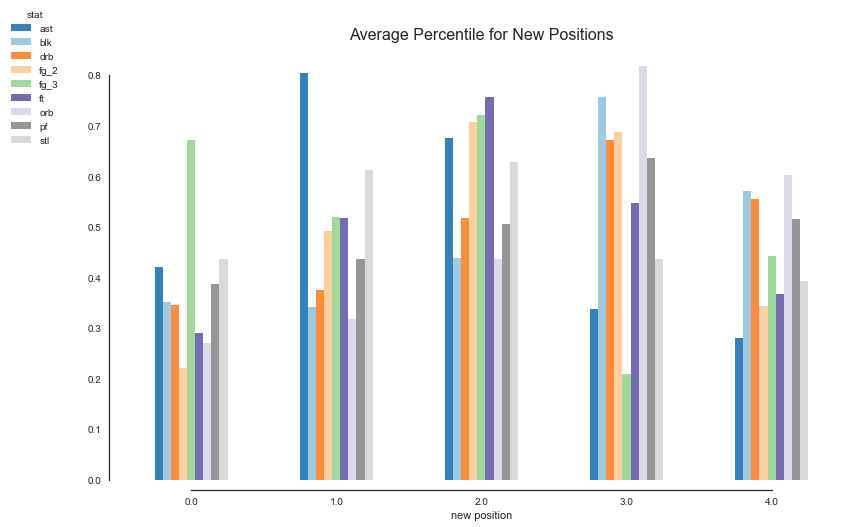

In [100]:
position_plot = df_percentiles.groupby('new_pos').mean()[df_morphed.columns].plot(kind="bar", figsize=(13,8), colormap="Vega20c")
sns.despine(offset=10, trim=True)
position_plot.set_xlabel("new position")
position_plot.legend(title="stat", loc='upper right', bbox_to_anchor=(-.07, 1.1))
position_plot.set_title("Average Percentile for New Positions", size=16)


In [69]:
# Ranking each position according to each stat.

In [70]:
not_per_game_stats = ['age', 'gp', 'gs', 'player', 'pos', 'new_pos']

# converting to per game numbers
for c in df.columns:
    if c not in not_per_game_stats:
        df[c] = df[c] / df['gp']

In [71]:
for c in df.columns:
    try:
        df[c] = df[c].astype(float)
        df[c] = [round(num, 2) for num in df[c]]
    except:
        pass

In [72]:
# Making a ranked dataframe

position_avg = df.groupby('new_pos').mean()[df_morphed.columns]

In [73]:
def rank_columns(df):
    new_df = df.copy()
    for c in new_df.columns:
        new_df[c] = stats.rankdata(df[c], "average").astype(int)
    return new_df

position_rank = rank_columns(position_avg)

In [83]:
new_columns = {
    'ast': "Assists",
    'blk': "Blocks",
    'drb': "Defensive Rebounds",
    'fg_2': "2-pointers",
    'fg_3': "3-pointers",
    'ft': "Free Throws",
    'orb': "Offensive Rebounds",
    'pf': 'Personal Fouls',
    'stl': 'Steals'
}

position_rank.rename(columns=new_columns, inplace=True)

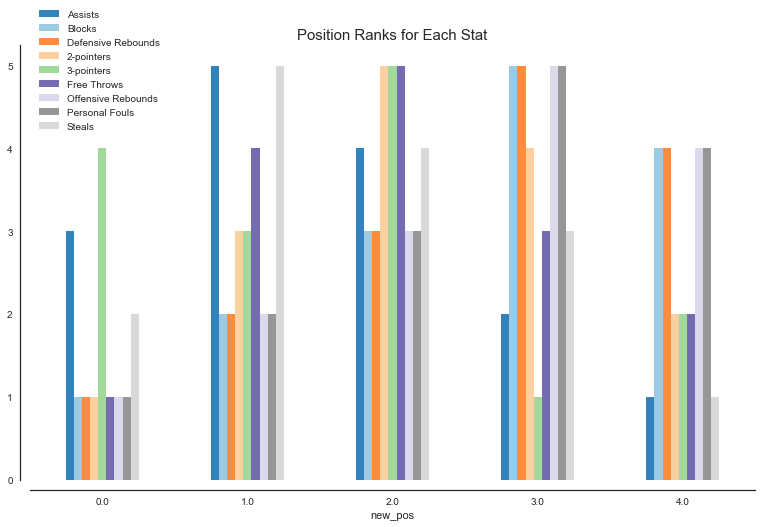

In [101]:
# Rank 5 indicates good, rank 1 indicates bad

pos_rank_plot = position_rank.plot(kind="bar", figsize=(13,8), colormap="Vega20c")
sns.despine(offset=10)
pos_rank_plot.legend(bbox_to_anchor=(0, 1.1), loc='upper left', ncol=1)
pos_rank_plot.set_title("Position Ranks for Each Stat", size=15)

Quick Thoughts on this chart:

Position 0:
Doesn't rank most highest in anything, but they're good at threes.  These are mostly our shooting guards, as we saw earlier.  They're actually dead last in everything except three categories, which indicates that they're highly focused on scoring and don't make other big measurable contributions in general.  You do see them getting a fair amount of assists though.

Position 1:
Mostly traditional point guards, these are the assisters and steal focused people, but they don't necessarily score a lot.  Though some are big time scorers.

Position 2:
This is a lot of your big time stars in the modern nba, the scoring specialists.  they rank highest in 2s, 3s, and free throws.  It's mostly shooting guards by traditional measures, by the top scorers in this category are scattered across all sorts of positions.  They're also facilitating the offense quite a bit, ranking 2nd in assists.  Though they're not getting as many assists as the pure facilitors of group 1, they do get more rebounds.

Position 3:
Traditional big man.  Though this doesn't include only centers, this category encapsulates most of the old school big men who still roam the NBA.  They rank last in 3 pointers, but they crush the boards, ranking first in offsenive and defensive rebounds.  They do get some scoring in, but mostly around the rim, ranking 2nd in 2 pointers.  They also rank first in personal fouls, which you tend to see with rebounding specialists because of all the fouls called on them while they jostle around the rim.

Position 4:
This is more of your stretch-4/mobile big that's become all the rage in the modern NBA.  They rank just below the traditional bigs in rebounds, fouls, and personal fouls, and score fewer 2s, but balance they by taking more 3s.  Their defensive contribution is more limited than the traditional bigs, ranking last in steals.

# Position 4:

Notable Players:
- Kevin Love
- Dirk Nowitzki
- Kelly Olynyk
- Dario Saric

In [104]:

df[df['new_pos'] == 4].sort_values('pts', ascending=False).head(20)

,age,ast,blk,drb,fg,fg_2,fg_2_a,fg_3,fg_3_a,fga,...,mp,orb,pf,player,pos,pts,stl,tov,trb,new_pos
272,28.0,1.93,0.37,8.63,6.17,3.75,7.97,2.42,6.48,14.45,...,31.42,2.47,2.08,Kevin Love,PF,19.03,0.88,2.03,11.10,4.0
54,26.0,2.20,0.20,4.89,6.53,4.56,9.05,1.96,5.04,14.09,...,33.36,1.18,2.56,Avery Bradley,SG,16.25,1.24,1.60,6.07,4.0
331,38.0,1.52,0.70,6.11,5.48,4.02,8.69,1.46,3.87,12.56,...,26.37,0.43,2.09,Dirk Nowitzki,PF,14.24,0.56,0.94,6.54,4.0
360,23.0,1.51,0.51,4.96,5.17,3.33,5.78,1.85,4.26,10.04,...,32.56,1.48,2.41,Otto Porter,SF,13.44,1.45,0.54,6.44,4.0
211,29.0,1.72,0.28,4.46,4.68,2.95,5.95,1.73,4.90,10.85,...,26.12,1.40,2.57,Ersan Ilyasova,PF,13.06,0.71,1.41,5.87,4.0
90,26.0,1.52,1.03,5.13,4.36,2.31,4.78,2.04,6.15,10.93,...,31.63,1.37,3.03,Robert Covington,SF,12.90,1.90,1.96,6.51,4.0
391,22.0,2.25,0.37,4.95,4.70,3.40,7.23,1.31,4.21,11.44,...,26.28,1.38,2.00,Dario Saric,PF,12.84,0.70,2.26,6.33,4.0
467,30.0,1.39,0.70,5.38,3.91,2.28,4.61,1.63,4.66,9.26,...,30.20,1.17,1.76,Marvin Williams,PF,11.17,0.76,0.79,6.55,4.0
306,25.0,1.07,0.80,4.61,3.69,1.84,3.54,1.84,5.39,8.93,...,23.99,0.87,1.83,Nikola Mirotic,PF,10.63,0.76,1.13,5.49,4.0
78,19.0,0.73,0.85,3.07,3.46,2.59,4.98,0.88,2.73,7.71,...,21.26,1.17,3.21,Marquese Chriss,PF,9.18,0.82,1.32,4.24,4.0


# Position 3:

Notable Players:
- Anthony Davis
- Rudy Gobert
- DeAndre Jordan
- Karl-Anthony Towns
- Hassan Whiteside
- Nikola Jokic

In [105]:
df[df['new_pos'] == 3].sort_values('trb', ascending=False).head(15)

,age,ast,blk,drb,fg,fg_2,fg_2_a,fg_3,fg_3_a,fga,...,mp,orb,pf,player,pos,pts,stl,tov,trb,new_pos
460,27.0,0.74,2.09,10.32,7.04,7.04,12.64,0.00,0.00,12.64,...,32.64,3.81,2.94,Hassan Whiteside,C,17.00,0.73,2.00,14.13,3.0
114,23.0,1.10,1.10,9.52,5.96,5.94,11.16,0.02,0.09,11.25,...,29.74,4.26,2.93,Andre Drummond,C,13.64,1.53,1.88,13.78,3.0
239,28.0,1.19,1.67,10.09,5.09,5.09,7.10,0.00,0.02,7.12,...,31.73,3.67,2.62,DeAndre Jordan,C,12.70,0.64,1.43,13.75,3.0
154,24.0,1.20,2.64,8.90,5.10,5.10,7.69,0.00,0.01,7.70,...,33.88,3.88,3.04,Rudy Gobert,C,14.04,0.60,1.83,12.78,3.0
204,31.0,1.41,1.24,8.70,5.24,5.24,8.26,0.00,0.03,8.28,...,29.72,4.00,2.74,Dwight Howard,C,13.54,0.86,2.30,12.70,3.0
432,21.0,2.68,1.26,8.67,9.78,8.55,14.68,1.23,3.35,18.04,...,36.95,3.61,2.94,Karl-Anthony Towns,C,25.13,0.70,2.59,12.28,3.0
99,23.0,2.09,2.23,9.49,10.27,9.73,18.56,0.53,1.79,20.35,...,36.11,2.32,2.24,Anthony Davis,C,27.99,1.25,2.41,11.81,3.0
446,26.0,2.77,0.99,8.04,6.44,6.13,12.75,0.31,1.00,13.75,...,28.84,2.35,2.40,Nikola Vucevic,C,14.61,1.03,1.56,10.39,3.0
158,32.0,1.48,0.79,7.45,4.76,4.76,8.20,0.00,0.02,8.22,...,31.17,2.90,2.60,Marcin Gortat,C,10.77,0.49,1.44,10.35,3.0
232,21.0,4.92,0.77,6.93,6.77,6.15,9.79,0.62,1.90,11.70,...,27.92,2.90,2.93,Nikola Jokic,C,16.73,0.84,2.34,9.84,3.0


# Position 2:

Notable Players:
- Russell Westbrook
- Kevin Durant
- Isaiah Thomas
- Paul George
- Jimmy Butler
- Kyrie Irving

In [77]:
df[df['new_pos'] == 2].sort_values('pts', ascending=False).head(15)

,age,ast,blk,drb,fg,fg_2,fg_2_a,fg_3,fg_3_a,fga,...,mp,orb,pf,player,pos,pts,stl,tov,trb,new_pos
457,28.0,10.37,0.38,8.98,10.17,7.70,16.77,2.47,7.20,23.96,...,34.59,1.69,2.35,Russell Westbrook,PG,31.58,1.64,5.41,10.67,2.0
423,27.0,5.91,0.17,2.13,8.97,5.75,10.88,3.22,8.50,19.38,...,33.80,0.57,2.20,Isaiah Thomas,PG,28.93,0.92,2.76,2.70,2.0
107,27.0,3.92,0.18,4.27,9.74,9.30,19.20,0.45,1.68,20.88,...,35.41,0.95,1.81,DeMar DeRozan,SG,27.30,1.05,2.43,5.22,2.0
265,26.0,5.85,0.27,4.29,8.81,5.96,12.13,2.85,7.71,19.84,...,35.92,0.61,2.03,Damian Lillard,PG,26.99,0.91,2.63,4.91,2.0
89,26.0,4.61,1.28,8.94,8.99,7.17,14.85,1.82,5.06,19.90,...,34.24,2.13,3.86,DeMarcus Cousins,C,26.97,1.39,3.74,11.07,2.0
260,25.0,3.51,0.74,4.73,8.59,6.61,12.50,1.99,5.22,17.72,...,33.43,1.08,1.65,Kawhi Leonard,SF,25.51,1.78,2.08,5.81,2.0
214,24.0,5.81,0.35,2.47,9.32,6.86,13.60,2.46,6.13,19.72,...,35.07,0.72,2.18,Kyrie Irving,PG,25.22,1.15,2.50,3.19,2.0
118,28.0,4.84,1.60,7.65,8.89,7.00,11.52,1.89,5.03,16.55,...,33.39,0.63,1.89,Kevin Durant,SF,25.08,1.06,2.23,8.27,2.0
65,27.0,5.49,0.42,4.49,7.50,6.30,13.21,1.20,3.26,16.47,...,36.96,1.70,1.47,Jimmy Butler,SF,23.89,1.88,2.09,6.18,2.0
149,26.0,3.35,0.36,5.79,8.29,5.69,11.37,2.60,6.61,17.99,...,35.85,0.77,2.75,Paul George,SF,23.67,1.56,2.91,6.56,2.0


# Position 1

Notable Players:
- James Harden
- Lebron James
- Stephen Curry
- Chris Paul
- Draymond Green
- Rajon Rondo

In [106]:
df[df['new_pos'] == 1].sort_values('ast', ascending=False).head(15)

,age,ast,blk,drb,fg,fg_2,fg_2_a,fg_3,fg_3_a,fga,...,mp,orb,pf,player,pos,pts,stl,tov,trb,new_pos
171,27.0,11.19,0.46,6.96,8.32,5.09,9.59,3.23,9.33,18.93,...,36.38,1.17,2.65,James Harden,PG,29.09,1.48,5.73,8.14,1.0
451,26.0,10.65,0.63,3.44,8.29,7.15,14.91,1.14,3.49,18.40,...,36.36,0.74,1.94,John Wall,PG,23.14,2.01,4.14,4.18,1.0
350,31.0,9.23,0.13,4.31,6.13,4.10,7.92,2.03,4.95,12.87,...,31.49,0.67,2.39,Chris Paul,PG,18.10,1.93,2.41,4.98,1.0
385,26.0,9.09,0.13,3.16,3.48,2.68,6.05,0.80,2.61,8.67,...,32.92,0.91,2.69,Ricky Rubio,PG,11.15,1.71,2.60,4.07,1.0
219,32.0,8.73,0.59,7.34,9.95,8.27,13.54,1.68,4.62,18.16,...,37.76,1.31,1.81,LeBron James,SF,26.41,1.24,4.09,8.65,1.0
419,28.0,7.79,0.39,3.63,4.90,3.80,8.01,1.10,3.07,11.09,...,32.40,0.40,2.01,Jeff Teague,PG,15.29,1.22,2.63,4.04,1.0
197,26.0,7.28,0.66,3.25,6.04,4.55,9.15,1.49,4.19,13.34,...,32.69,0.69,1.99,Jrue Holiday,PG,15.36,1.49,2.90,3.94,1.0
163,26.0,7.01,1.39,6.59,3.58,2.51,5.09,1.07,3.46,8.55,...,32.51,1.29,2.86,Draymond Green,PF,10.21,2.03,2.42,7.88,1.0
273,30.0,6.95,0.32,4.00,7.10,3.88,7.50,3.22,7.80,15.30,...,37.40,0.80,2.83,Kyle Lowry,PG,22.40,1.47,2.88,4.80,1.0
381,30.0,6.68,0.16,4.09,3.32,2.59,6.20,0.72,1.93,8.13,...,26.71,1.06,2.09,Rajon Rondo,PG,7.80,1.43,2.43,5.14,1.0


# Position 0

Notable Players:
- J.R. Smith
- Eric Gordon
- Kyle Korver
- Trevor Ariza

In [107]:
df[df['new_pos'] == 0].sort_values('fg_3', ascending=False).head(15)

,age,ast,blk,drb,fg,fg_2,fg_2_a,fg_3,fg_3_a,fga,...,mp,orb,pf,player,pos,pts,stl,tov,trb,new_pos
157,28.0,2.51,0.53,2.29,5.49,2.21,4.73,3.28,8.81,13.55,...,30.97,0.39,2.00,Eric Gordon,SG,16.23,0.64,1.61,2.68,0.0
479,31.0,0.97,0.23,1.87,4.53,1.70,3.53,2.83,7.02,10.55,...,25.93,0.42,2.28,Nick Young,SG,13.18,0.62,0.60,2.28,0.0
14,28.0,0.94,0.19,3.03,4.49,1.65,3.71,2.83,7.03,10.74,...,29.39,1.56,1.97,Ryan Anderson,PF,13.60,0.44,0.76,4.58,0.0
247,35.0,1.64,0.31,2.67,3.57,1.15,2.33,2.42,5.36,7.69,...,26.16,0.12,1.60,Kyle Korver,SG,10.12,0.51,1.03,2.79,0.0
121,29.0,1.13,0.06,1.85,3.73,1.32,2.60,2.40,6.35,8.95,...,24.19,0.29,1.13,Wayne Ellington,SG,10.45,0.56,0.48,2.15,0.0
18,31.0,2.19,0.25,5.06,4.08,1.69,3.04,2.39,6.94,9.97,...,34.66,0.68,1.66,Trevor Ariza,SF,11.70,1.84,0.93,5.74,0.0
282,30.0,2.88,0.22,3.30,4.56,2.18,5.04,2.38,6.56,11.60,...,34.18,0.25,2.21,Wesley Matthews,SG,13.51,1.05,1.40,3.55,0.0
406,31.0,1.51,0.27,2.34,3.00,0.68,2.07,2.32,6.61,8.68,...,28.95,0.41,1.88,J.R. Smith,SG,8.56,0.98,0.63,2.76,0.0
301,29.0,0.63,0.33,2.62,3.70,1.47,3.13,2.22,5.38,8.51,...,23.37,0.39,1.99,C.J. Miles,SF,10.72,0.61,0.53,3.01,0.0
94,26.0,2.15,0.32,5.10,4.63,2.44,4.53,2.18,5.47,10.00,...,32.43,0.67,2.24,Jae Crowder,SF,13.88,1.00,1.10,5.76,0.0


In [187]:
df_per_game.columns

Index([u'age', u'ast', u'blk', u'drb', u'fg', u'fg_2', u'fg_2_a', u'fg_3',
       u'fg_3_a', u'fga', u'ft', u'fta', u'gp', u'gs', u'mp', u'orb', u'pf',
       u'player', u'pos', u'pts', u'stl', u'tov', u'trb', u'new_pos'],
      dtype='object')

In [121]:
position_titles = {
    0: "Three Point Specialist",
    1: "Facilitator",
    2: "Designated Scorer",
    3: "Stationary Big",
    4: "Mobile Big"
}

df['pos_title'] = [position_titles[pos] for pos in df['new_pos']]

In [123]:
df['text'] = df['player'] + " : " + df['pos_title']

In [127]:
import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks

# colors = ['red', 'blue', 'yellow', 'green', 'black']
# color_map = [colors[i] for pos in df_per_game.new_pos]

trace1 = go.Scatter3d(
    x=df['pts'],
    y=df['trb'],
    z=df['ast'],
    mode='markers',
    text=df['text'],
    marker=dict(
        size=12,
        color=df['new_pos'],             # set color to an array/list of desired values
        colorscale='Jet',                     # choose a colorscale
        opacity=0.8,
    )
)

data = [trace1]

layout = go.Layout(
#                     title='New Position Clusters',
                    scene = dict(
                    xaxis = dict(
                        title='Points'),
                    yaxis = dict(
                        title='Rebounds'),
                    zaxis = dict(
                        title='Assists'),),
                    width=700,
                    margin=dict(
                    r=20, b=10,
                    l=10, t=10),    
                  )
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='new_pos_pts_ast_reb')

In [125]:
import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks

# colors = ['red', 'blue', 'yellow', 'green', 'black']
# color_map = [colors[i] for pos in df_per_game.new_pos]

trace1 = go.Scatter3d(
    x=df['blk'],
    y=df['stl'],
    z=df['trb'],
    mode='markers',
    text=df['text'],
    marker=dict(
        size=12,
        color=df['new_pos'],             # set color to an array/list of desired values
        colorscale='Jet',                     # choose a colorscale
        opacity=0.8,
    )
)

data = [trace1]

layout = go.Layout( #showlegend=True,
                    scene = dict(
                    xaxis = dict(
                        title='Blocks'),
                    yaxis = dict(
                        title='Steals'),
                    zaxis = dict(
                        title='Rebounds'),),
                    width=700,
                    margin=dict(
                    r=20, b=10,
                    l=10, t=10)
                  )
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='new_pos_blk_stl_reb')

We can see from this plot that the traditional centers excel in steals and blocks, while the traditional distributor/point guards are weak in those categories but stronger in steals.  Draymond Green is actually a bit of an anomily in the distributor category, because he's so strong in blocks and assists.  Steals is actually something that differentiates traditional 'centers' who are now in my 'modern star' category.  players like Joel Embiid and Anthony Davis stick out from the centers on steals, while still being really strong in rebounds and blocks.

In [130]:
trace1 = go.Scatter3d(
    x=df['fg_3'],
    y=df['fg_2'],
    z=df['pts'],
    mode='markers',
    text=df['text'],
    marker=dict(
        size=12,
        color=df['new_pos'],             # set color to an array/list of desired values
        colorscale='Jet',                     # choose a colorscale
        opacity=0.8,
    )
)

data = [trace1]

layout = go.Layout( #showlegend=True,
                    scene = dict(
                    xaxis = dict(
                        title='Three Point FGs'),
                    yaxis = dict(
                        title='Two Point FGs'),
                    zaxis = dict(
                        title='Points'),),
                    width=700,
                    margin=dict(
                    r=20, b=10,
                    l=10, t=10)
                  )
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='new_pos_3s_2s_FGA')

This plot really distinguishes well between the stationary bigs, the designated scorers, and the three point specialists. The three point specialists shoot a much higher proportion of threes, while the designated scorers category is more balnced between twos and threes, and the bigs hardly make any threes.  The facilitators and mobile bigs take less of both, but similar to the scorers, they take a more balanced amount of each.